In [1]:
import time
import numpy as np
import pandas as pd
from MedicareBLP import BLP, data
import os
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

In [2]:
#Initialize data directory.
dir =os.path.join(os.getcwd(), 'Data')

In [3]:
# #Helper function which we take from our Problem Set 2 code to output regression tables.
# def output_table(models, instruments):
#     if len(instruments) != len(models):
#         raise ValueError("Length of instrument labels must match the number of models.")
    
#     all_vars = sorted({var for model in models.values() for var in model.params.index if not var.startswith("C(")})

#     def star_format(coef, p):
#         return f"{coef:.4f}{'***' if p <= 0.01 else '**' if p <= 0.05 else '*' if p <= 0.1 else ''}"

#     results = {
#         "Variable": all_vars + ["Observations", "Instruments"],
#         **{
#             name: [
#                 star_format(model.params.get(var, float('nan')), model.pvalues.get(var, float('nan'))) 
#                 if var in model.params else " " 
#                 for var in all_vars
#             ] + [f"{model.nobs:.0f}", fe]
#             for (name, model), fe in zip(models.items(), instruments)
#         }
#     }
#     table_df = pd.DataFrame(results)
#     latex_output = table_df.to_latex(index=False).splitlines()
#     latex_output.insert(-4, r"\midrule")
#     return "\n".join(latex_output)

def output_table(models, instruments):
    if len(instruments) != len(models):
        raise ValueError("Length of instrument labels must match the number of models.")

    all_vars = sorted({var for model in models.values() for var in model.params.index if not var.startswith("C(")})

    def star_format(coef, p):
        return f"{coef:.4f}{'***' if p <= 0.01 else '**' if p <= 0.05 else '*' if p <= 0.1 else ''}"

    def get_standard_error(model, var):
        if hasattr(model, 'bse'):  # For statsmodels OLS
            return model.bse.get(var, float('nan'))
        elif hasattr(model, 'std_errors'):  # For linearmodels IV2SLS
            return model.std_errors.get(var, float('nan'))
        else:
            raise AttributeError("Model does not have recognized standard error attributes.")

    results = {
        "Variable": all_vars + ["Observations", "Instruments"],
        **{
            name: [
                f"\\makecell{{{star_format(model.params.get(var, float('nan')), model.pvalues.get(var, float('nan')))}\\\\"
                f"({get_standard_error(model, var):.4f})}}"
                if var in model.params else " "
                for var in all_vars
            ] + [f"{model.nobs:.0f}", fe]
            for (name, model), fe in zip(models.items(), instruments)
        }
    }
    table_df = pd.DataFrame(results)
    latex_output = table_df.to_latex(index=False, escape=False, column_format="l" + "c" * len(models)).splitlines()
    latex_output.insert(-4, r"\midrule")  
    return "\n".join(latex_output)

def start_routine(data, theta2w, mtol, niter, options):
    starttime = time.time()
    blp = BLP(data,theta2w,mtol,niter)
    init_theta = blp.init_theta(theta2w) 
    res = blp.iterate_optimization(opt_func=blp.gmmobj,param_vec=init_theta,jac=blp.gradobj,options=options) 
    blp.results(res)
    endtime=time.time()
    print(f'Running time: {str(endtime-starttime)}')

    return blp

def format_number(x):
    # Check if it's a number
    if isinstance(x, (int, float)):
        return f"{x:.2f}".rstrip('.')
    return x  

In [ ]:
#Load data for Logit Estimation
logit_dat = os.path.join(dir, 'PartD.csv')
data_raw = pd.read_csv(logit_dat,sep=',',encoding='cp1252')
dt = data_raw.loc[:,('regionid', #Grouping variable, dummies
                     'year', #Grouping variable, dummies
                     'enrol_tot_num', #For market shares
                     'enrol_lis_num', #For market shares
                     'pdp', #Grouping variable
                     'Part_D_Total_Premium', #Endgoenous variable
                     'basic', #Nesting variable
                     'Part_D_Drug_Deductible', #Exogenous plan characteristic
                     'unrestricted_drug', #Exogenous plan characteristic
                     'in_area_flag', #Exogenous plan characteristic
                     'Parent_Organization', #Grouping variable
                     'Part_D_Basic_Premium', #Not used - high correlation with Part_D_Total_Premium
                     'n_medications', #Additional plan characteristic
                     'top_drug', #Additional plan characteristic
                     'drug_frf' #Unused
                     ) 
                     ]


/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_20799/3279966648.py:3: DtypeWarning: Columns (19,76) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(logit_dat,sep=',',encoding='cp1252')


In [5]:
#Missing Data
dt['enrol_lis_num'].isna().sum()
dt=dt.loc[dt['enrol_lis_num'].isna()==0,:]
print(f"Remaining columns with NaN values: {dt.columns[dt.isna().any()].tolist()}")

Remaining columns with NaN values: ['unrestricted_drug', 'in_area_flag', 'Part_D_Basic_Premium', 'n_medications', 'top_drug', 'drug_frf']


In [6]:
#Dummies (drop one to avoid multicollinearity)
#Baseline groups captured in regression constant: XLHealth Corporation, region 34, year 2013

dummies_organization=pd.get_dummies(dt.loc[:,'Parent_Organization'] ).drop('XLHealth Corporation',axis=1) 
#dummies_region=pd.get_dummies(dt.loc[:,'regionid'] ).drop(34,axis=1) 
#dummies_year=pd.get_dummies(dt.loc[:,'year']).drop(2013,axis=1)   

#Region dummies
dummies_region = pd.get_dummies(dt['regionid'], prefix='region')
baseline = 'region_34'
if baseline in dummies_region.columns:
    dummies_region.drop(columns=baseline, inplace=True)

#Year dummies 
dummies_year = pd.get_dummies(dt['year'], prefix='year')
baseline = 'year_2013'
if baseline in dummies_year.columns:
    dummies_year.drop(columns=baseline, inplace=True)

# Year x Region Dummies - Leads to singular matrix in IV regression
dt['region_year'] = dt['regionid'].astype(str) + '_' + dt['year'].astype(str)
dummies_region_year = pd.get_dummies(dt['region_year'], prefix='regyear')
ref_col = 'regyear_34_2013'  
if ref_col in dummies_region_year.columns:
    dummies_region_year.drop(columns=ref_col, inplace=True)

#Align on index
dt= dt.join([dummies_organization,dummies_region,dummies_year, dummies_region_year])
dt.drop(columns=['region_year'], inplace=True)

#Convert dummies to int
dt[dt.select_dtypes(include = 'bool').columns] = dt[dt.select_dtypes(include = 'bool').columns].astype(int)

In [7]:
#Market shares
dt['mkt_id']= dt['regionid'].apply(str)+dt['year'].apply(str)
dt['demand'] = dt.enrol_tot_num - dt.enrol_lis_num
#Demand for outside good plans
s0 = dt.loc[dt['pdp']==0].groupby('mkt_id').sum().demand 
#Total demand in each market
s = dt.groupby('mkt_id').sum().demand  

#Market total and outside good total
mj= dt.loc[dt['pdp']==1].join(s, on='mkt_id',rsuffix='_total').join(s0,on='mkt_id',rsuffix='_0')
m= mj.assign(mkt_sh_j= lambda x: x['demand']/x['demand_total']).assign(mkt_sh_0= lambda x: x['demand_0']/x['demand_total'])
m

/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_20799/3498212942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dt['mkt_id']= dt['regionid'].apply(str)+dt['year'].apply(str)
/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_20799/3498212942.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dt['demand'] = dt.enrol_tot_num - dt.enrol_lis_num


,regionid,year,enrol_tot_num,enrol_lis_num,pdp,Part_D_Total_Premium,basic,Part_D_Drug_Deductible,unrestricted_drug,in_area_flag,...,regyear_9_2010,regyear_9_2011,regyear_9_2012,regyear_9_2013,mkt_id,demand,demand_total,demand_0,mkt_sh_j,mkt_sh_0
23656,11,2013,106.0,38.0,1,31.600000,1,325,254.0,4037.0,...,0,0,0,0,112013,68.0,3.439070e+05,265630.003204,0.000198,0.772389
23657,34,2013,439.0,315.0,1,34.099998,1,325,254.0,97.0,...,0,0,0,0,342013,124.0,3.275000e+03,NaN,0.037863,NaN
23658,33,2013,654.0,573.0,1,32.599998,1,325,254.0,205.0,...,0,0,0,0,332013,81.0,3.565200e+04,33301.000000,0.002272,0.934057
23660,13,2013,24.0,0.0,1,36.299999,1,325,254.0,2379.0,...,0,0,0,0,132013,24.0,1.186291e+05,72699.103479,0.000202,0.612827
23661,24,2013,25.0,0.0,1,38.299999,1,325,254.0,604.0,...,0,0,0,0,242013,25.0,7.768393e+04,9757.932783,0.000322,0.125611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35138,11,2007,512.0,130.0,1,24.900000,1,265,NaN,NaN,...,0,0,0,0,112007,382.0,1.112025e+06,578116.353636,0.000344,0.519877
35139,11,2006,778.0,164.0,1,48.440000,1,250,48.0,3733.0,...,0,0,0,0,112006,614.0,1.025408e+06,531972.000000,0.000599,0.518791
35140,3,2007,51.0,0.0,1,44.700000,0,0,NaN,NaN,...,0,0,0,0,32007,51.0,5.499360e+05,306937.985719,0.000093,0.558134
35141,3,2007,17.0,0.0,1,28.100000,0,0,NaN,NaN,...,0,0,0,0,32007,17.0,5.499360e+05,306937.985719,0.000031,0.558134


In [8]:
#Include basic premium or not?
m['Part_D_Basic_Premium'].corr(m['Part_D_Total_Premium'])

np.float64(0.8331188794167514)

In [9]:
#Regression without instruments.
log_s_j_s_0 = np.log(m['mkt_sh_j'])-np.log(m['mkt_sh_0'])
y = log_s_j_s_0.mask(np.isinf(log_s_j_s_0) | np.isnan(log_s_j_s_0))
y.name='y'

#Dummies for Region x Year: comment out if not wanted!
##########################################################################
m.columns = m.columns.map(str)
regyear_cols = [col for col in m.columns if col.startswith('regyear_')]
year_cols = [col for col in m.columns if col.startswith('year_')]
region_cols = [col for col in m.columns if col.startswith('region_')]
##########################################################################
#x = m.loc[:,('Part_D_Total_Premium','basic','Part_D_Drug_Deductible','unrestricted_drug','in_area_flag', regyear)]
x = m[['Part_D_Total_Premium',
     'basic',
     'Part_D_Drug_Deductible',
     'unrestricted_drug',
     'in_area_flag',
     'n_medications',
     #'drug_frf',
     'top_drug'
     ] 
     + region_cols 
]
x=sm.add_constant(x)
model1 = sm.OLS(y,x, missing='drop').fit() 
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:03:09   Log-Likelihood:                -17509.
No. Observations:                9180   AIC:                         3.510e+04
Df Residuals:                    9139   BIC:                         3.539e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

/Users/roylehmann/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master/Bocconi/Semester 3/Empirical Industrial Organizations/Python/Computational Assignment/BLP_EST/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#IV Regression - Hausman Instruments

#Hausman Instruments
IV=dt.loc[dt['pdp']==1,('Part_D_Total_Premium','Parent_Organization','basic','regionid','year')]
temp1=IV.groupby(['Parent_Organization','basic','regionid','year']).sum()
temp2=IV.groupby(['Parent_Organization','basic','regionid','year']).count()
IV=IV.join(temp1,on=['Parent_Organization','basic','regionid','year'],rsuffix='_mktsum')
IV=IV.join(temp2,on=['Parent_Organization','basic','regionid','year'],rsuffix='_mktcount')

temp3=IV.groupby(['Parent_Organization','basic','year']).sum().Part_D_Total_Premium
temp4=IV.groupby(['Parent_Organization','basic','year']).count().Part_D_Total_Premium
IV=IV.join(temp3,on=['Parent_Organization','basic','year'],rsuffix='_allsum')
IV=IV.join(temp4,on=['Parent_Organization','basic','year'],rsuffix='_allcount')

ivhaus=(IV.Part_D_Total_Premium_allsum-IV.Part_D_Total_Premium_mktsum).div(IV.Part_D_Total_Premium_allcount-IV.Part_D_Total_Premium_mktcount)
ivhaus.name='ivhausman'
m2=x.join(ivhaus).join(y)
m2=m2.dropna()
m2

,const,Part_D_Total_Premium,basic,Part_D_Drug_Deductible,unrestricted_drug,in_area_flag,n_medications,top_drug,region_1,region_2,...,region_26,region_27,region_28,region_29,region_30,region_31,region_32,region_33,ivhausman,y
23656,1.0,31.600000,1,325,254.0,4037.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,0,0,35.100000,-8.270352
23658,1.0,32.599998,1,325,254.0,205.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,0,1,35.065517,-6.018894
23660,1.0,36.299999,1,325,254.0,2379.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,0,0,34.937931,-8.016031
23661,1.0,38.299999,1,325,254.0,604.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,0,0,34.868965,-5.966960
23662,1.0,34.599998,1,325,254.0,1569.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,0,0,34.996551,-7.341666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35028,1.0,70.600000,0,0,402.0,3508.0,2342.0,86.0,0,0,...,0,0,0,0,0,0,0,0,63.709091,-7.456543
35084,1.0,44.100000,1,0,625.0,2322.0,3370.0,95.0,0,0,...,0,0,0,0,0,0,0,0,44.100000,-8.539973
35085,1.0,34.000000,1,0,590.0,2310.0,3730.0,93.0,0,0,...,0,0,0,0,0,0,0,0,27.500000,-8.765098
35135,1.0,64.099998,0,0,424.0,3666.0,3381.0,90.0,0,0,...,0,0,0,0,0,0,0,0,58.799999,-6.136041


In [11]:
#2SLS Regression
endo=m2['Part_D_Total_Premium']
exo=m2[['const',
        #'basic',
        'Part_D_Drug_Deductible',
        'unrestricted_drug',
        'in_area_flag',
        'n_medications',
        'top_drug',
        #'drug_frf'
        ] 
        + region_cols
]
model2=IV2SLS(m2.y,exo,endo, m2['ivhausman']).fit()
print(model2.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.3936
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3909
No. Observations:                8795   F-statistic:                    3928.1
Date:                Mon, Dec 23 2024   P-value (F-stat)                0.0000
Time:                        01:03:20   Distribution:                 chi2(39)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                      1.5708     0.3426     4.5856     0.0000      0.8994      2.2422
Part

In [12]:
print(model2.first_stage)

         First Stage Estimation Results        
                           Part_D_Total_Premium
-----------------------------------------------
R-squared                                0.6907
Partial R-squared                        0.5818
Shea's R-squared                         0.5818
Partial F-statistic                      9651.8
P-value (Partial F-stat)                 0.0000
Partial F-stat Distn                    chi2(1)
==========================          ===========
const                                    0.9318
                                       (0.6531)
Part_D_Drug_Deductible                  -0.0093
                                      (-10.301)
unrestricted_drug                       -0.0003
                                      (-0.2419)
in_area_flag                             0.0005
                                       (1.2508)
n_medications                            0.0001
                                       (2.4534)
top_drug                                

In [ ]:
#Prepares data for nested logit
total_nest=m.groupby(['regionid','year','basic']).sum().mkt_sh_j 
m3= m.join(total_nest, on=['regionid','year','basic'], how='left',rsuffix='_nest')
m3=m3.assign(s_nest= lambda x: np.log(x['mkt_sh_j']/x['mkt_sh_j_nest']))
m3=x.join(ivhaus).join(y).join(m3['s_nest'])
m3=m3.dropna()
m3

In [14]:
#Simple OLS regression with nesting variable - Both nesting variable and total premium are endogenous.
x3=m3[['const', 
       'Part_D_Total_Premium', 
       #'basic', 
       'Part_D_Drug_Deductible',
       'unrestricted_drug',
       'in_area_flag', 
       's_nest', 
       'n_medications', 
       'top_drug', 
       #'drug_frf'
    ]
       + region_cols
]
model3 = sm.OLS(m3.y,x3, missing='drop').fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1675.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:03:40   Log-Likelihood:                -9343.2
No. Observations:                8795   AIC:                         1.877e+04
Df Residuals:                    8754   BIC:                         1.906e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5

In [15]:
#Construct BLP Instrument for nesting variable

############################################################################
#BLP instrument based on deductible
############################################################################
ivblp=dt.loc[dt['pdp']==1,('Part_D_Drug_Deductible','basic','regionid','year')]
temp1=ivblp.groupby(['basic','regionid','year']).sum()
temp2=ivblp.groupby(['basic','regionid','year']).count()
ivblp=ivblp.join(temp1,on=['basic','regionid','year'],rsuffix='_mktsum')
ivblp=ivblp.join(temp2,on=['basic','regionid','year'],rsuffix='_mktcount')

temp3=ivblp.groupby(['basic','year']).sum().Part_D_Drug_Deductible
temp4=ivblp.groupby(['basic','year']).count().Part_D_Drug_Deductible
ivblp=ivblp.join(temp3,on=['basic','year'],rsuffix='_allsum')
ivblp=ivblp.join(temp4,on=['basic','year'],rsuffix='_allcount')

ivblp=(ivblp.Part_D_Drug_Deductible_allsum-ivblp.Part_D_Drug_Deductible_mktsum).div(ivblp.Part_D_Drug_Deductible_allcount-ivblp.Part_D_Drug_Deductible_mktcount) 
ivblp.name='ivblp'
m3=m3.join(ivblp)
m3=m3.dropna()
m3


,const,Part_D_Total_Premium,basic,Part_D_Drug_Deductible,unrestricted_drug,in_area_flag,n_medications,top_drug,region_1,region_2,...,region_28,region_29,region_30,region_31,region_32,region_33,ivhausman,y,s_nest,ivblp
23656,1.0,31.600000,1,325,254.0,4037.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,35.100000,-8.270352,-1.043182,307.982143
23658,1.0,32.599998,1,325,254.0,205.0,3112.0,81.0,0,0,...,0,0,0,0,0,1,35.065517,-6.018894,-2.654806,310.224299
23660,1.0,36.299999,1,325,254.0,2379.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,34.937931,-8.016031,-3.491444,309.460177
23661,1.0,38.299999,1,325,254.0,604.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,34.868965,-5.966960,-5.722670,307.982143
23662,1.0,34.599998,1,325,254.0,1569.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,34.996551,-7.341666,0.000000,308.280702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35028,1.0,70.600000,0,0,402.0,3508.0,2342.0,86.0,0,0,...,0,0,0,0,0,0,63.709091,-7.456543,-5.756052,11.170732
35084,1.0,44.100000,1,0,625.0,2322.0,3370.0,95.0,0,0,...,0,0,0,0,0,0,44.100000,-8.539973,-8.092221,230.105125
35085,1.0,34.000000,1,0,590.0,2310.0,3730.0,93.0,0,0,...,0,0,0,0,0,0,27.500000,-8.765098,-8.443430,188.574713
35135,1.0,64.099998,0,0,424.0,3666.0,3381.0,90.0,0,0,...,0,0,0,0,0,0,58.799999,-6.136041,-5.202161,31.524064


In [16]:
endo2 = m3[['Part_D_Total_Premium', 's_nest']] 
exo2  = m3[['const',
            #'basic', 
            'Part_D_Drug_Deductible',
            'unrestricted_drug',
            'in_area_flag', 
            'n_medications', 
            'top_drug', 
            #'drug_frf'
        ]
        + region_cols
    ]  

model4 = IV2SLS(
    dependent=m3['y'], 
    exog=exo2, 
    endog=endo2, 
    instruments=m3[['ivhausman', 'ivblp']]
).fit()

print(model4.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.7422
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7410
No. Observations:                8795   F-statistic:                 1.091e+04
Date:                Mon, Dec 23 2024   P-value (F-stat)                0.0000
Time:                        01:03:50   Distribution:                 chi2(40)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                      8.2093     0.5698     14.406     0.0000      7.0924      9.3261
Part

In [17]:
print(model4.first_stage)

               First Stage Estimation Results              
                           Part_D_Total_Premium      s_nest
-----------------------------------------------------------
R-squared                                0.6922      0.1672
Partial R-squared                        0.5837      0.0076
Shea's R-squared                         0.5528      0.0072
Partial F-statistic                      9723.0      54.389
P-value (Partial F-stat)                 0.0000   1.547e-12
Partial F-stat Distn                    chi2(2)     chi2(2)
==========================          =========== ===========
const                                   -0.4334     -5.0290
                                      (-0.3031)   (-28.247)
Part_D_Drug_Deductible                  -0.0156     -0.0043
                                      (-15.576)   (-19.343)
unrestricted_drug                       -0.0003     -0.0022
                                      (-0.2707)   (-11.132)
in_area_flag                            

In [18]:
############################################################################
#BLP instrument based on unrestricted_drug
############################################################################
m3.drop(columns=['ivblp'], inplace=True)
ivblp=dt.loc[dt['pdp']==1,('unrestricted_drug','basic','regionid','year')]
temp1=ivblp.groupby(['basic','regionid','year']).sum()
temp2=ivblp.groupby(['basic','regionid','year']).count()
ivblp=ivblp.join(temp1,on=['basic','regionid','year'],rsuffix='_mktsum')
ivblp=ivblp.join(temp2,on=['basic','regionid','year'],rsuffix='_mktcount')

temp3=ivblp.groupby(['basic','year']).sum().unrestricted_drug
temp4=ivblp.groupby(['basic','year']).count().unrestricted_drug
ivblp=ivblp.join(temp3,on=['basic','year'],rsuffix='_allsum')
ivblp=ivblp.join(temp4,on=['basic','year'],rsuffix='_allcount')

ivblp=(ivblp.unrestricted_drug_allsum-ivblp.unrestricted_drug_mktsum).div(ivblp.unrestricted_drug_allcount-ivblp.unrestricted_drug_mktcount) 
ivblp.name='ivblp'
m3=m3.join(ivblp)
m3=m3.dropna()
m3

,const,Part_D_Total_Premium,basic,Part_D_Drug_Deductible,unrestricted_drug,in_area_flag,n_medications,top_drug,region_1,region_2,...,region_28,region_29,region_30,region_31,region_32,region_33,ivhausman,y,s_nest,ivblp
23656,1.0,31.600000,1,325,254.0,4037.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,35.100000,-8.270352,-1.043182,366.723214
23658,1.0,32.599998,1,325,254.0,205.0,3112.0,81.0,0,0,...,0,0,0,0,0,1,35.065517,-6.018894,-2.654806,366.177570
23660,1.0,36.299999,1,325,254.0,2379.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,34.937931,-8.016031,-3.491444,366.814159
23661,1.0,38.299999,1,325,254.0,604.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,34.868965,-5.966960,-5.722670,366.964286
23662,1.0,34.599998,1,325,254.0,1569.0,3112.0,81.0,0,0,...,0,0,0,0,0,0,34.996551,-7.341666,0.000000,367.956140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35028,1.0,70.600000,0,0,402.0,3508.0,2342.0,86.0,0,0,...,0,0,0,0,0,0,63.709091,-7.456543,-5.756052,457.953271
35084,1.0,44.100000,1,0,625.0,2322.0,3370.0,95.0,0,0,...,0,0,0,0,0,0,44.100000,-8.539973,-8.092221,514.642643
35085,1.0,34.000000,1,0,590.0,2310.0,3730.0,93.0,0,0,...,0,0,0,0,0,0,27.500000,-8.765098,-8.443430,464.928922
35135,1.0,64.099998,0,0,424.0,3666.0,3381.0,90.0,0,0,...,0,0,0,0,0,0,58.799999,-6.136041,-5.202161,384.470219


In [20]:
endo3 = m3[['Part_D_Total_Premium', 's_nest']] 
exo3  = m3[['const',
            #'basic', 
            'Part_D_Drug_Deductible',
            'unrestricted_drug',
            'in_area_flag', 
            'n_medications', 
            'top_drug', 
            #'drug_frf'
        ]
        + region_cols 
    ]  
model5 = IV2SLS(
    dependent=m3['y'], 
    exog=exo3, 
    endog=endo3, 
    instruments=m3[['ivhausman', 'ivblp']]
).fit()

print(model5.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                      y   R-squared:                      0.6105
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6087
No. Observations:                8795   F-statistic:                    6166.3
Date:                Mon, Dec 23 2024   P-value (F-stat)                0.0000
Time:                        01:04:03   Distribution:                 chi2(40)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                      2.6651     0.4673     5.7031     0.0000      1.7492      3.5810
Part

In [21]:
print(model5.first_stage)

               First Stage Estimation Results              
                           Part_D_Total_Premium      s_nest
-----------------------------------------------------------
R-squared                                0.6908      0.1739
Partial R-squared                        0.5819      0.0156
Shea's R-squared                         0.5617      0.0151
Partial F-statistic                      9648.7      120.99
P-value (Partial F-stat)                 0.0000      0.0000
Partial F-stat Distn                    chi2(2)     chi2(2)
==========================          =========== ===========
const                                   -0.8103     -2.8536
                                      (-0.4058)   (-10.830)
Part_D_Drug_Deductible                  -0.0098     -0.0027
                                      (-10.305)   (-14.901)
unrestricted_drug                       -0.0006     -0.0018
                                      (-0.4940)   (-9.5118)
in_area_flag                            

In [22]:
#Convert all models to latex table
models = {"\makecell{Logit \\\(OLS)}": model1, 
          "\makecell{Logit \\\(TSLS)}": model2, 
          "\makecell{Nested Logit \\\(OLS)}": model3, 
          "\makecell{Nested Logit \\\(TSLS)}": model4, 
          "\makecell{Nested Logit 2 \\\(TSLS)}": model5
          }
latex = output_table(models, ["No", "Hausman", "No", "Hausman, BLP", "Hausman, BLP2"])
print(latex)

\begin{tabular}{lccccc}
\toprule
Variable & \makecell{Logit \\(OLS)} & \makecell{Logit \\(TSLS)} & \makecell{Nested Logit \\(OLS)} & \makecell{Nested Logit \\(TSLS)} & \makecell{Nested Logit 2 \\(TSLS)} \\
\midrule
Part_D_Drug_Deductible & \makecell{-0.0046***\\(0.0002)} & \makecell{-0.0035***\\(0.0002)} & \makecell{-0.0002***\\(0.0001)} & \makecell{0.0011***\\(0.0004)} & \makecell{-0.0027***\\(0.0003)} \\
Part_D_Total_Premium & \makecell{-0.0148***\\(0.0009)} & \makecell{-0.0135***\\(0.0011)} & \makecell{-0.0074***\\(0.0004)} & \makecell{-0.0091***\\(0.0008)} & \makecell{-0.0128***\\(0.0010)} \\
basic & \makecell{0.3460***\\(0.0530)} &   &   &   &   \\
const & \makecell{1.3589***\\(0.2064)} & \makecell{1.5708***\\(0.3426)} & \makecell{5.7613***\\(0.0914)} & \makecell{8.2093***\\(0.5698)} & \makecell{2.6651***\\(0.4673)} \\
in_area_flag & \makecell{0.0007***\\(0.0001)} & \makecell{0.0008***\\(0.0001)} & \makecell{0.0000\\(0.0000)} & \makecell{-0.0004***\\(0.0001)} & \makecell{0.0006***

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_20799/3951618827.py:2: SyntaxWarning: invalid escape sequence '\m'
  models = {"\makecell{Logit \\\(OLS)}": model1,
/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_20799/3951618827.py:3: SyntaxWarning: invalid escape sequence '\m'
  "\makecell{Logit \\\(TSLS)}": model2,
/var/folders/1p/vc1972d933j3yxvvwfgbm0vh0000gn/T/ipykernel_20799/3951618827.py:4: SyntaxWarning: invalid escape sequence '\m'
  "\makecell{Nested Logit \\\(OLS

In [23]:
print(model2.first_stage.summary.as_latex())
print(model4.first_stage.summary.as_latex())
print(model5.first_stage.summary.as_latex())

\begin{center}
\begin{tabular}{lc}
\toprule
                                    & \textbf{Part\_D\_Total\_Premium}  \\
\midrule
\textbf{R-squared}                  &              0.6907               \\
\textbf{Partial R-squared}          &              0.5818               \\
\textbf{Shea's R-squared}           &              0.5818               \\
\textbf{Partial F-statistic}        &              9651.8               \\
\textbf{P-value (Partial F-stat)}   &              0.0000               \\
\textbf{Partial F-stat Distn}       &             chi2(1)               \\
\textbf{==========================} &           ===========             \\
\textbf{const}                      &              0.9318               \\
\textbf{}                           &             (0.6531)              \\
\textbf{Part\_D\_Drug\_Deductible}  &             -0.0093               \\
\textbf{}                           &            (-10.301)              \\
\textbf{unrestricted\_drug}         &          

In [ ]:
#Creating data objects
data_0 = data(dir) #Default
data_1 = data(dir, exp_1=True) #Add variable in x1
data_2 = data(dir, exp_2=True) #Adding group of IVs
data_3 = data(dir, exp_3=True) #Adding characteristic into x2
data_0.summary()
data_1.summary()
data_2.summary()
data_3.summary()

In [6]:
labels = ['Premium',
           'Deductible',
            '# Medications',
            'Drug FRF',
            'Coverage Gap',
            'Enhanced Plan',
            'Top Drug',
            'In Area Flag',
            'Vintage',
            'Tier 12'
            ]
product_chars = data_1.data.iloc[:,143:153].copy()
product_chars = product_chars.apply(pd.to_numeric, errors='coerce')
product_chars.columns = labels
descr = product_chars.describe()
descr = descr.map(format_number)
print(descr.to_latex())

\begin{tabular}{lllllllllll}
\toprule
 & Premium & Deductible & # Medications & Drug FRF & Coverage Gap & Enhanced Plan & Top Drug & In Area Flag & Vintage & Tier 12 \\
\midrule
count & 8331.00 & 8331.00 & 8331.00 & 8331.00 & 8331.00 & 8331.00 & 8331.00 & 8331.00 & 8331.00 & 8331.00 \\
mean & 42.46 & 113.82 & 3840.50 & 871.73 & 0.25 & 0.48 & 85.58 & 1816.08 & 2.92 & 72.85 \\
std & 20.14 & 131.93 & 1173.86 & 176.61 & 0.43 & 0.50 & 14.67 & 1331.96 & 1.58 & 18.43 \\
min & 1.87 & 0.00 & 1970.00 & 310.00 & 0.00 & 0.00 & 27.00 & 0.00 & 1.00 & 3.00 \\
25% & 28.80 & 0.00 & 3010.00 & 785.00 & 0.00 & 0.00 & 85.00 & 779.00 & 2.00 & 66.00 \\
50% & 37.10 & 0.00 & 3408.00 & 914.00 & 0.00 & 0.00 & 90.00 & 1485.00 & 3.00 & 75.00 \\
75% & 49.50 & 265.00 & 4415.00 & 985.00 & 0.00 & 1.00 & 94.00 & 2340.00 & 4.00 & 88.00 \\
max & 136.80 & 310.00 & 7339.00 & 1187.00 & 1.00 & 1.00 & 103.00 & 10548.00 & 6.00 & 96.00 \\
\bottomrule
\end{tabular}



In [7]:
#Set run options
#####################################################################################
niter = 2500
theta2w = np.array([0.50,-0.5,0.5]) 
mtol= 1e-5 
options={'disp': None,'maxiter': 100,'xatol':0.0001,'fatol':0.0001}
#####################################################################################

[ 0.5 -0.5  0.5]
['# of iterations for delta convergence: ', 76]
fval: 1786.1288763228013
[ 0.525 -0.5    0.5  ]
['# of iterations for delta convergence: ', 4]
fval: 1786.7768070178786
[ 0.5   -0.525  0.5  ]
['# of iterations for delta convergence: ', 45]
fval: 1896.072520476402
[ 0.5   -0.5    0.525]
['# of iterations for delta convergence: ', 45]
fval: 1792.7414887151217
[ 0.51666667 -0.475       0.51666667]
['# of iterations for delta convergence: ', 43]
fval: 1686.459954350077
[ 0.525 -0.45   0.525]
['# of iterations for delta convergence: ', 43]
fval: 1589.80589733456
[ 0.53333333 -0.46666667  0.49166667]
['# of iterations for delta convergence: ', 41]
fval: 1646.811429108774
[ 0.51388889 -0.44444444  0.51111111]
['# of iterations for delta convergence: ', 42]
fval: 1564.4472950735735
[ 0.50833333 -0.41666667  0.51666667]
['# of iterations for delta convergence: ', 43]
fval: 1463.4595444631204
[ 0.54444444 -0.38888889  0.52222222]
['# of iterations for delta convergence: ', 42]
fv

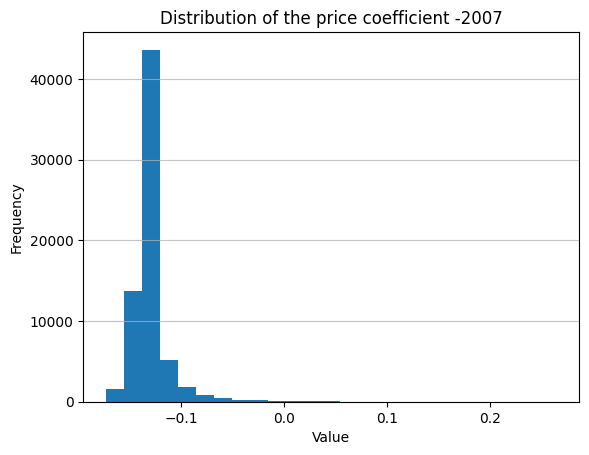

In [8]:
#Run the baseline case:
blp1 = start_routine(data_0, theta2w, mtol, niter, options)

In [13]:
blp1.gradobj(blp1.theta2)

this is the gradient [[-2.44248779e-03]
 [-3.89288226e+01]
 [-5.86426375e-01]]


array([[-2.44248779e-03],
       [-3.89288226e+01],
       [-5.86426375e-01]])

[ 0.5 -0.5  0.5]
['# of iterations for delta convergence: ', 78]
fval: 1013.1381748735241
[ 0.525 -0.5    0.5  ]
['# of iterations for delta convergence: ', 4]
fval: 1013.6288104631782
[ 0.5   -0.525  0.5  ]
['# of iterations for delta convergence: ', 45]
fval: 1065.111490587337
[ 0.5   -0.5    0.525]
['# of iterations for delta convergence: ', 45]
fval: 1025.106568398785
[ 0.51666667 -0.475       0.51666667]
['# of iterations for delta convergence: ', 43]
fval: 972.8972007364301
[ 0.525 -0.45   0.525]
['# of iterations for delta convergence: ', 43]
fval: 931.9347054655177
[ 0.53333333 -0.46666667  0.49166667]
['# of iterations for delta convergence: ', 41]
fval: 946.1766658900037
[ 0.51388889 -0.44444444  0.51111111]
['# of iterations for delta convergence: ', 42]
fval: 915.5653310290047
[ 0.50833333 -0.41666667  0.51666667]
['# of iterations for delta convergence: ', 43]
fval: 872.9910688179814
[ 0.54444444 -0.38888889  0.52222222]
['# of iterations for delta convergence: ', 42]
fval

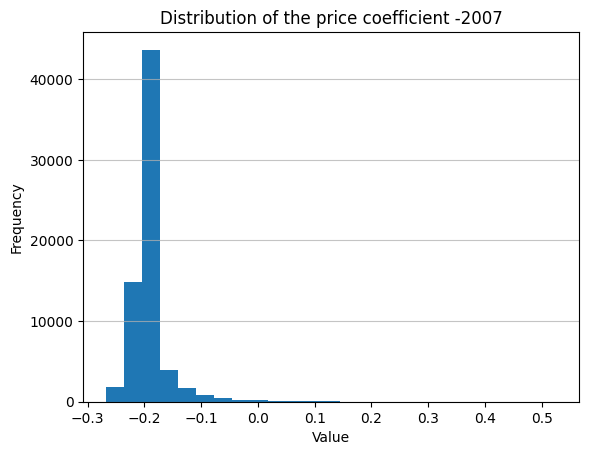

In [14]:
blp2 = start_routine(data_1, theta2w, mtol, niter, options)

In [15]:
blp2.gradobj(blp2.theta2)

this is the gradient [[ -0.26588999]
 [-48.29494102]
 [ -1.90188706]]


array([[ -0.26588999],
       [-48.29494102],
       [ -1.90188706]])

[ 0.5 -0.5  0.5]
['# of iterations for delta convergence: ', 75]
fval: 9017.960092351374
[ 0.525 -0.5    0.5  ]
['# of iterations for delta convergence: ', 4]
fval: 9017.967474151485
[ 0.5   -0.525  0.5  ]
['# of iterations for delta convergence: ', 45]
fval: 9881.082620445242
[ 0.5   -0.5    0.525]
['# of iterations for delta convergence: ', 45]
fval: 9033.780645359744
[ 0.51666667 -0.475       0.51666667]
['# of iterations for delta convergence: ', 43]
fval: 8208.433895324255
[ 0.525 -0.45   0.525]
['# of iterations for delta convergence: ', 43]
fval: 7436.787792890851
[ 0.53333333 -0.46666667  0.49166667]
['# of iterations for delta convergence: ', 41]
fval: 7929.4657321229515
[ 0.51388889 -0.44444444  0.51111111]
['# of iterations for delta convergence: ', 42]
fval: 7262.028734536921
[ 0.50833333 -0.41666667  0.51666667]
['# of iterations for delta convergence: ', 43]
fval: 6464.81560548607
[ 0.54444444 -0.38888889  0.52222222]
['# of iterations for delta convergence: ', 42]
fval: 

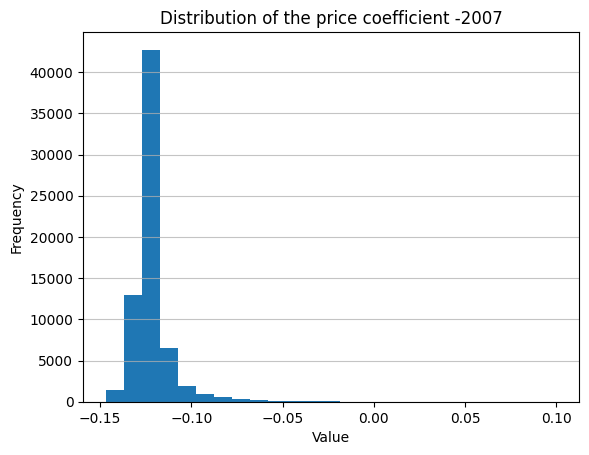

In [16]:
blp3 = start_routine(data_2, theta2w, mtol, niter, options)

[ 0.2  -0.01  0.01 -0.5   0.05  0.05]
['# of iterations for delta convergence: ', 46]
fval: 9220.73210985471
[ 0.21 -0.01  0.01 -0.5   0.05  0.05]
['# of iterations for delta convergence: ', 5]
fval: 9181.866437322278
[ 0.2    -0.0105  0.01   -0.5     0.05    0.05  ]
['# of iterations for delta convergence: ', 5]
fval: 9123.257075073796
[ 0.2    -0.01    0.0105 -0.5     0.05    0.05  ]
['# of iterations for delta convergence: ', 7]
fval: 9106.615994691045
[ 0.2   -0.01   0.01  -0.525  0.05   0.05 ]
['# of iterations for delta convergence: ', 14]
fval: 9024.24645555211
[ 0.2    -0.01    0.01   -0.5     0.0525  0.05  ]
['# of iterations for delta convergence: ', 21]
fval: 9719.200734165363
[ 0.2    -0.01    0.01   -0.5     0.05    0.0525]
['# of iterations for delta convergence: ', 26]
fval: 8798.78724807238
[ 0.20333333 -0.01016667  0.01016667 -0.50833333  0.0475      0.05083333]
['# of iterations for delta convergence: ', 31]
fval: 7953.581235424975
[ 0.205   -0.01025  0.01025 -0.5125 

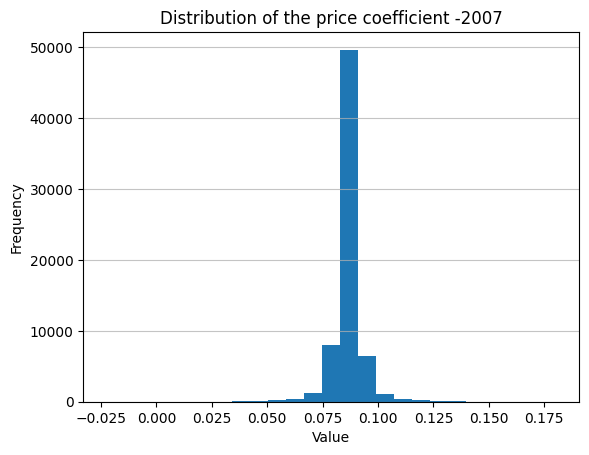

In [54]:
theta2w = np.array([0.20,-0.01,0.01,-0.5,0.05,0.05])
blp4 = start_routine(data_3, theta2w, mtol, niter, options)

In [10]:
blp4.varcov(blp4.theta2).diagonal()

array([5.06764245e+00, 4.69865942e+01, 1.79518006e+01, 5.71035544e-01,
       8.97922201e+03, 3.44330364e+02, 9.84887733e+00, 8.55983347e+01,
       1.11830581e-01, 1.60020181e+02, 6.76745185e+03, 2.36722182e+04,
       1.16722752e+04, 4.68174223e+02, 5.02837482e+02, 1.44757133e+03,
       3.88046327e+03, 5.05318040e+03, 1.88132467e+03, 1.57392477e+03,
       3.53611049e-02, 1.87809575e+01, 3.20679327e+02, 6.38601824e-03,
       8.50576777e-01])

In [11]:
product_chars_x1_0 = ['Constant', 'Price', 'Deductible', 'Drug FRF', 'Coverage Gap', 
                      'Enhanced Plan', 'Tier 12', 'Top Drug', 'In Area Flag', 'Vintage']
product_chars_x1_1 = product_chars_x1_0 + ['N Medications']
cases = ['Baseline', 'Case 1', 'Case 2', 'Case 3']

In [12]:
#Retrieve theta1
theta1_0 = blp1.theta1_results[0:len(product_chars_x1_0)] #Baseline
theta1_1 = blp2.theta1_results[0:len(product_chars_x1_1)] #With n_medications in x1
theta1_2 = blp3.theta1_results[0:len(product_chars_x1_0)] #With extra instruments
theta1_3 = blp4.theta1_results[0:len(product_chars_x1_0)] #With extra variable in x2

In [51]:
#Retrieve theta 2
theta2_0 = blp1.theta2_results
theta2_1 = blp2.theta2_results
theta2_2 = blp3.theta2_results
theta2_3 = blp4.theta2_results[3:]

In [14]:
#Retrieve value of the objective function at the optimum
fval_0 = blp1.gmmvalnew
fval_1 = blp2.gmmvalnew
fval_2 = blp3.gmmvalnew
fval_3 = blp4.gmmvalnew

In [15]:
# Helper function to format cell values
def format_row_data(index, thetas):
    return [
        f"{theta.iloc[index, 0]:.3f} ({theta.iloc[index, 1]:.3f})"
        if index < len(theta) and pd.notna(theta.iloc[index, 0]) else ""
        for theta in thetas
    ]

# Generate table rows
def generate_rows(header, characteristics, thetas):
    rows = [[f"\\multicolumn{{5}}{{l}}{{\\textbf{{{header}}}}} \\\\"]]
    for i, char in enumerate(characteristics):
        row = [char] + format_row_data(i, thetas)
        if any(cell != "--" for cell in row[1:]):  # Only include rows with data
            rows.append(row)
    return rows

# Add Theta 1 and Theta 2 rows
table_rows = generate_rows("Theta 1", product_chars_x1_1, [theta1_0, theta1_1, theta1_2, theta1_3])
table_rows.append(["\\midrule", "", "", "", ""])
table_rows += generate_rows("Theta 2", [f"Theta2\\_{i+1}" for i in range(len(theta2_0))],
                            [theta2_0, theta2_1, theta2_2, theta2_3])
table_rows.append(["\\midrule", "", "", "", ""])
table_rows.append(["\\multicolumn{5}{l}{\\textbf{GMM}} \\\\"])

# Add fval row
fval_row = ["fval"] + [f"{fval:.3f}" if pd.notna(fval) else "--" for fval in [fval_0, fval_1, fval_2, fval_3]]
if any(cell != "--" for cell in fval_row[1:]):  # Only include row if it has data
    table_rows.append(fval_row)

# Convert to DataFrame and export to LaTeX
df = pd.DataFrame(table_rows, columns=["Product Characteristics"] + cases)
latex_table = df.to_latex(
    index=False, escape=False, column_format="lcccc",
    caption="BLP Estimation Results", label="tab:blp_results"
).replace("NaN", "")
print(latex_table)



\begin{table}
\caption{BLP Estimation Results}
\label{tab:blp_results}
\begin{tabular}{lcccc}
\toprule
Product Characteristics & Baseline & Case 1 & Case 2 & Case 3 \\
\midrule
\multicolumn{5}{l}{\textbf{Theta 1}} \\ &  &  &  &  \\
Constant & -1.302 (2.575) & 30.699 (7.909) & -0.045 (2.285) & 0.556 (2.251) \\
Price & -12.871 (1.779) & -19.024 (3.302) & -12.097 (1.682) & -14.110 (6.855) \\
Deductible & -0.690 (0.052) & -1.184 (0.141) & -0.693 (0.052) & -1.486 (4.237) \\
Drug FRF & 1.492 (0.270) & -0.102 (0.560) & 1.632 (0.238) & 1.537 (0.756) \\
Coverage Gap & 259.916 (34.494) & 435.420 (65.122) & 250.878 (31.908) & 285.141 (94.759) \\
Enhanced Plan & 4.243 (10.486) & -72.303 (22.574) & 0.892 (8.618) & 3.073 (18.556) \\
Tier 12 & 1.423 (0.822) & -2.354 (1.298) & 0.995 (0.646) & 0.621 (3.138) \\
Top Drug & -18.541 (4.539) & -44.839 (8.195) & -21.033 (3.969) & -19.945 (9.252) \\
In Area Flag & -0.147 (0.033) & -0.182 (0.046) & -0.137 (0.023) & -0.189 (0.334) \\
Vintage & 72.476 (5.346) & 

In [40]:
blp1.theta2_results

,Theta2,Std.Error_theta2
0,-0.168514,9.625228
1,0.015102,0.014071
2,0.043436,1.693562


In [48]:
def format_results(results_df, value_col, error_col):
    return results_df.apply(
        lambda row: f"{row[value_col]:.4f} ({row[error_col]:.4f})", axis=1
    )

blp_objects = {"Baseline": blp1, "Case 1": blp2, "Case 2": blp3, "Case 3": blp4}

max_theta1_length = max(len(obj.theta1_results) for obj in blp_objects.values())
max_theta2_length = max(len(obj.theta2_results) for obj in blp_objects.values())

data_dict = {}

for case, blp_obj in blp_objects.items():
    theta1_results = blp_obj.theta1_results
    formatted_theta1 = format_results(
        theta1_results, value_col="Theta1", error_col="Std.Error_theta1"
    )
    
    theta2_results = blp_obj.theta2_results
    formatted_theta2 = format_results(
        theta2_results, value_col="Theta2", error_col="Std.Error_theta2"
    )
    
    formatted_theta1 = formatted_theta1.reindex(range(max_theta1_length), fill_value=np.nan)
    formatted_theta2 = formatted_theta2.reindex(range(max_theta2_length), fill_value=np.nan)
    
    data_dict[case] = pd.concat([formatted_theta1, formatted_theta2]).reset_index(drop=True)

final_df = pd.DataFrame(data_dict)
final_df.insert(0, "Parameter", ["Theta1"] * max_theta1_length + ["Theta2"] * max_theta2_length)
final_df.drop(['Parameter'], axis=1, inplace=True)
print(final_df.to_latex(index=False))


\begin{tabular}{llll}
\toprule
Baseline & Case 1 & Case 2 & Case 3 \\
\midrule
-1.3021 (2.5750) & 30.6985 (7.9091) & -0.0454 (2.2846) & 0.5557 (2.2511) \\
-12.8711 (1.7794) & -19.0244 (3.3021) & -12.0975 (1.6821) & -14.1098 (6.8547) \\
-0.6895 (0.0520) & -1.1836 (0.1406) & -0.6931 (0.0516) & -1.4864 (4.2370) \\
1.4920 (0.2700) & -0.1018 (0.5603) & 1.6323 (0.2383) & 1.5374 (0.7557) \\
259.9156 (34.4943) & 435.4197 (65.1218) & 250.8781 (31.9076) & 285.1411 (94.7588) \\
4.2433 (10.4861) & -72.3029 (22.5742) & 0.8921 (8.6175) & 3.0730 (18.5561) \\
1.4233 (0.8221) & -2.3539 (1.2983) & 0.9949 (0.6456) & 0.6212 (3.1383) \\
-18.5410 (4.5386) & -44.8386 (8.1954) & -21.0328 (3.9692) & -19.9453 (9.2519) \\
-0.1469 (0.0327) & -0.1824 (0.0465) & -0.1371 (0.0231) & -0.1891 (0.3344) \\
72.4763 (5.3463) & 75.9633 (7.9007) & 69.4660 (4.0375) & 75.6492 (12.6499) \\
91.4604 (13.4610) & 0.4301 (0.0981) & 86.2082 (10.9073) & 108.6817 (82.2645) \\
127.8009 (17.8792) & 107.1750 (22.5353) & 120.2295 (13.7320)